<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# MicroProyecto 2:  Clasificación de Textos

El objetivo del proyecto es desarrollar una solución basada en técnicas de procesamiento del lenguaje natural y machine learning, que permita clasificar automáticamente un texto según los 17 Objetivos de Desarrollo Sostenible -ODS- ó SDGs por sus siglas en inglés, ofreciendo una forma de presentación de resultados a través de una herramienta de fácil comprensión para el usuario final.

## Actividades para realizar

1. Preparación de los textos utilizando el esquema de bolsa de palabras (BOW)l con una pesado
TF-IDF. Para este paso construir un pipeline que integre las transformaciones que se
consideren adecuadas.

2. Desarrollo de un modelo de clasificación que permita relacionar un texto con un ODS. Para
manejar la complejidad del espacio de entrada aplicar un algoritmo de reducción de la
dimensionalidad.

3. Evaluación del modelo con textos que no hayan sido utilizados para el aprendizaje

## Desarrollo


### 0. Carga de Librerias

In [33]:
#running on MAIA_FPLN

import re
import unidecode
#import tarfile
#import zipfile
import pandas as pd
import numpy as np
#import pickle
#from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
# Linear regression
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import langdetect
import spacy

import matplotlib.pyplot as plt
import seaborn as sns



### 1. Carga de datos 

Para poder hacer la clasificación de acuerdo a los 17 objetivos para el desarrollo sostenible (ODS)  hemos creado un archivo ods.csv con tal información a partir de la descripción disponible en esta página: https://sdgs.un.org/goals#. Preferimos hacer uns traducción al español que utilizar la información disponible en la página en español: https://www.un.org/sustainabledevelopment/es/sustainable-development-goals/

In [2]:
# Cargamos los datos 
Train_textosODS = pd.read_excel('data/Train_textosODS.xlsx')
Train_textosODS.head()

,textos,ODS
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,No dejar clara la naturaleza de estos riesgos ...,6
2,"Como resultado, un mayor y mejorado acceso al ...",13
3,Con el Congreso firmemente en control de la ju...,16
4,"Luego, dos secciones finales analizan las impl...",5


In [3]:
Train_textosODS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9656 entries, 0 to 9655
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  9656 non-null   object
 1   ODS     9656 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 151.0+ KB


In [27]:
Train_textosODS["ODS"].value_counts().sort_index()

ODS
1      505
2      369
3      894
4     1025
5     1070
6      695
7      787
8      446
9      343
10     352
11     607
12     312
13     464
14     377
15     330
16    1080
Name: count, dtype: int64

In [4]:
# Cargamos los ODS
ods = pd.read_csv('data/ods.csv')
ods.head(17)

,ODS,objetivo,descripcion
0,1,Fin de la Pobreza,Acabar con la pobreza en todas sus formas en t...
1,2,Hambre Cero,"Poner fin al hambre, lograr la seguridad alime..."
2,3,Salud y Bienestar,Garantizar una vida sana y promover el bienest...
3,4,Educación de Calidad,"Garantizar una educación inclusiva, equitativa..."
4,5,Igualdad de Género,Lograr la igualdad de género y empoderar a tod...
5,6,Agua Limpia y Saneamiento,Garantizar la disponibilidad de agua y su gest...
6,7,Energía Asequible y No Contaminante,"Garantizar el acceso a una energía asequible, ..."
7,8,Trabajo Decente y Crecimiento Económico,"Promover el crecimiento económico sostenido, i..."
8,9,"Industria, Innovación e Infraestructura","Construir infraestructuras resilientes, promov..."
9,10,Reducción de las Desigualdades,Reducir la desigualdad en y entre los países.


In [5]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ODS          17 non-null     int64 
 1   objetivo     17 non-null     object
 2   descripcion  17 non-null     object
dtypes: int64(1), object(2)
memory usage: 540.0+ bytes


#### Separación Muestra de Evaluación

Siguiendo el ciclo de Machine Learning separamos una porción de los datos para hacer la evaluación una vez concluida la etapa de modelado. 

In [6]:
data, eva = train_test_split(Train_textosODS, test_size=0.2, random_state=77)
data.head()

,textos,ODS
5157,La definición y creación del Derecho contractu...,16
9635,Las principales preocupaciones se relacionan c...,15
8715,"Varios países, incluidos Austria, Alemania y S...",8
7397,Esto fue ligeramente más alto que el promedio ...,4
8792,"Del mismo modo, las estrategias nacionales de ...",13


In [7]:
data.shape

(7724, 2)

### 2. Exploración de Datos

La siguiente es la descripción de las variables provista en zenodo.org

doi - Digital Object Identifier of the original document<br>
text_id - unique text identifier<br>
text - text excerpt from the document<br>
sdg - the SDG the text is validated against<br>
labels_negative - the number of volunteers who rejected the suggested SDG label<br>
labels_positive - the number of volunteers who accepted the suggested SDG label<br>
agreement - agreement score based on the formula <br>


In [31]:
data[["textos"]].describe()

,textos
count,7724
unique,7724
top,La definición y creación del Derecho contractu...
freq,1


In [8]:
# Verificación del lenguaje de los textos:
from langdetect import detect
# Function to detect language
def detect_language(text):
    try:
        return detect(text)  
    except:
        return "unknown"

In [12]:
# Apply function to create a new column
data['lenguaje'] = data['textos'].apply(detect_language)

In [13]:
languaje_stats = pd.DataFrame(columns=['Unique Values', 'Count', 'Frequency', 'Top'])
unique_values = data["lenguaje"].unique()
unique_count = len(unique_values)
top_value = data["lenguaje"].mode().iloc[0]
top_freq = data["lenguaje"].value_counts().iloc[0]
languaje_stats.loc["lenguaje"] = [unique_values, unique_count, top_freq, top_value]
languaje_stats

,Unique Values,Count,Frequency,Top
lenguaje,"[es, pt, en]",3,7722,es


In [14]:
data["lenguaje"].value_counts()

lenguaje
es    7722
pt       1
en       1
Name: count, dtype: int64

In [15]:
data['word_count'] = data['textos'].str.split().str.len()
data['word_count'].describe()

count    7724.000000
mean      110.887623
std        37.218130
min        27.000000
25%        82.000000
50%       105.000000
75%       135.000000
max       260.000000
Name: word_count, dtype: float64

In [21]:
ods_stats = pd.DataFrame(columns=['Unique Values', 'Count', 'Frequency', 'Top'])
unique_values = data["ODS"].unique()
unique_count = len(unique_values)
top_value = data["ODS"].mode().iloc[0]
top_freq = data["ODS"].value_counts().iloc[0]
ods_stats.loc["ODS"] = [unique_values, unique_count, top_freq, top_value]
ods_stats

,Unique Values,Count,Frequency,Top
ODS,"[16, 15, 8, 4, 13, 6, 5, 9, 10, 3, 14, 12, 11,...",16,879,5


In [26]:
data["ODS"].value_counts().sort_index()

ODS
1     400
2     296
3     719
4     792
5     879
6     558
7     612
8     357
9     271
10    275
11    509
12    232
13    367
14    308
15    273
16    876
Name: count, dtype: int64

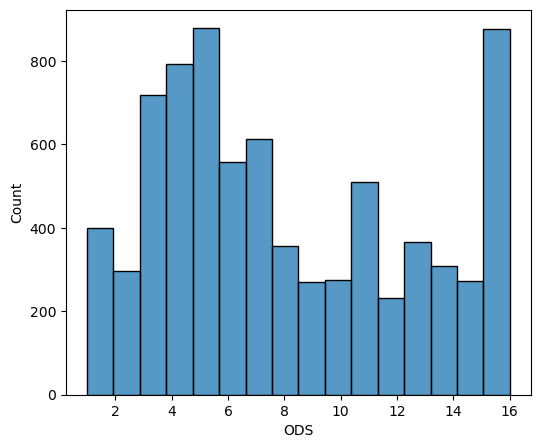

In [28]:
plt.figure(figsize=(6, 5))
sns.histplot(data["ODS"], bins=16)
plt.show();

### Procedimiento:

Se cargan los textos de la carpeta data.  La base cuenta con dos columnas que incluyen los textos a clasificar, y el objetivo bajo el cual está clasificado. La Base original cuenta con 9656 textos, en tanto que la muestra definida para hacer el entrenamiento tiene 7724. Todos los textos son únicos. En promedio cada texto tiene 112 palabras, el texto mas corto tiene 27 palabras, y el más largo 260.<br>

Finalmente, no existen textos clasificados bajo el objetivo # 17, y el objetivo con mayor número de textos clasificados debajo suyo es el #5: Igualdad de Género, con 879 textos. El que tiene menos es el #12: Producción y Consumo Responsables,  con 232 textos. Por lo tanto existe desbalance de clases.

### 2. Preparación de los datos. 

- Construir representaciones vectoriales de documentos para su análisis por algoritmos de aprendizaje.
- Aplicar técnicas de reducción de la dimensionalidad sobre textos para resolver problemas de aprendizaje y visualización.
- Caracterizar las fases del proceso de desarrollo de un proyecto de machine learning.
- Identificar las diferencias entre los métodos de reducción de la dimensionalidad por selección y por transformación OJO!!!

# Se borran las observaciones que están en lenguajes diferentes al español?  OJO!!!!

In [71]:
X = data['textos']
Y = data['ODS']
# stratify=Y: Ensures that the train and test splits maintain the same class proportions as the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state= 77, stratify=Y)

In [95]:
from sklearn.preprocessing import LabelEncoder

# Encode y_train and y_test to ensure classes start from 0
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


### 2.1 Limpieza de Texto

In [ ]:
# Cargamos las librerías a utilizar
import re
import unidecode

In [ ]:
#!pip install spacy

In [ ]:
#!python -m spacy download es_core_news_sm

In [34]:
import spacy

# Cargar el modelo para el idioma deseado (por ejemplo, español)
nlp = spacy.load("es_core_news_sm")
# nlp = spacy.load("es_core_news_lg") # High-Quality Spanish Model

In [35]:
len(nlp.Defaults.stop_words)

521

In [36]:
nlp.Defaults.stop_words

{'a',
 'acuerdo',
 'adelante',
 'ademas',
 'además',
 'afirmó',
 'agregó',
 'ahi',
 'ahora',
 'ahí',
 'al',
 'algo',
 'alguna',
 'algunas',
 'alguno',
 'algunos',
 'algún',
 'alli',
 'allí',
 'alrededor',
 'ambos',
 'ante',
 'anterior',
 'antes',
 'apenas',
 'aproximadamente',
 'aquel',
 'aquella',
 'aquellas',
 'aquello',
 'aquellos',
 'aqui',
 'aquél',
 'aquélla',
 'aquéllas',
 'aquéllos',
 'aquí',
 'arriba',
 'aseguró',
 'asi',
 'así',
 'atras',
 'aun',
 'aunque',
 'añadió',
 'aún',
 'bajo',
 'bastante',
 'bien',
 'breve',
 'buen',
 'buena',
 'buenas',
 'bueno',
 'buenos',
 'cada',
 'casi',
 'cierta',
 'ciertas',
 'cierto',
 'ciertos',
 'cinco',
 'claro',
 'comentó',
 'como',
 'con',
 'conmigo',
 'conocer',
 'conseguimos',
 'conseguir',
 'considera',
 'consideró',
 'consigo',
 'consigue',
 'consiguen',
 'consigues',
 'contigo',
 'contra',
 'creo',
 'cual',
 'cuales',
 'cualquier',
 'cuando',
 'cuanta',
 'cuantas',
 'cuanto',
 'cuantos',
 'cuatro',
 'cuenta',
 'cuál',
 'cuáles',
 'cu

In [37]:
from nltk.stem.snowball import SpanishStemmer # Prefiero no usar
stemmer = SpanishStemmer()
words= ['corro', 'correr', 'correria']
stemmed_words = [stemmer.stem(word) for word in words]
stemmed_words

['corr', 'corr', 'correri']

In [51]:
import warnings
#warnings.filterwarnings('ignore', category=DeprecationWarning)
import unidecode
import re

def text_cleaning(text):  
    # NLP object
    doc = nlp(text)
    
    # Eliminar Stopwords
    out = [token.text for token in doc if not token.is_stop]
    out = " ".join(out)
    
    # Eliminar caracteres especiales
    out = re.sub("[^\\w\\s]|\n", ' ', out)  # Remove punctuation and newlines
    out = re.sub("\d+", ' ', out)  # Remove numbers
    out = re.sub('\s+', ' ', out)  # Remove extra spaces
    out = out.lower()  # Convert to lowercase
    
    # Obtener los lemas de cada palabra
    lemmas = [token.lemma_ for token in nlp(out)]
    out = " ".join(lemmas)
    
    # Apply unidecode to remove accents, si lo hago antes el lematizador lo reintroduce
    out = unidecode.unidecode(out)  
    
    # Remove words that are too short (<= 2 characters)
    out = [token for token in out.split() if len(token) > 2]
    
    return " ".join(out)

#### Limpiar el texto

In [72]:
X_train_clean = X_train.apply(text_cleaning)

#### Asi se veria el texto limpio en el DF

In [53]:
data['texto_limpio'] = data['textos'].apply(text_cleaning)

In [54]:
data['texto_limpio'].head(3)

5157    definicion creacion derecho contractual arraig...
9635    principal preocupacion relacionar impacto acti...
8715    pais incluido austria alemania suiza sistema a...
Name: texto_limpio, dtype: object

In [55]:
data.head()

,textos,ODS,lenguaje,word_count,texto_limpio
5157,La definición y creación del Derecho contractu...,16,es,161,definicion creacion derecho contractual arraig...
9635,Las principales preocupaciones se relacionan c...,15,es,119,principal preocupacion relacionar impacto acti...
8715,"Varios países, incluidos Austria, Alemania y S...",8,es,68,pais incluido austria alemania suiza sistema a...
7397,Esto fue ligeramente más alto que el promedio ...,4,es,183,ligeramente alto promedio ocde hora educacion ...
8792,"Del mismo modo, las estrategias nacionales de ...",13,es,64,estrategia nacional cambio climatico existente...


### Procedimiento y Análisis

XXXXXX

### 2.2. Representación Vectorial

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Definimos el objeto TF-IDF Vectorizer Object
tfidf = TfidfVectorizer()

In [73]:
#Construimos la matriz TF-IDF

tfidf_matrix = tfidf.fit_transform(X_train_clean)

#Dimensiones de la matriz
tfidf_matrix.shape

(5793, 19154)

In [74]:
print("Total non-zero elements in the tfidf_matrix: ", len(tfidf_matrix.data))
print("Length of the column indices array in tfidf_matrix: ", len(tfidf_matrix.indices))
print("Length of the row pointer array in tfidf_matrix: ", len(tfidf_matrix.indptr))

Total non-zero elements in the tfidf_matrix:  243658
Length of the column indices array in tfidf_matrix:  243658
Length of the row pointer array in tfidf_matrix:  5794


In [75]:
# Convertir la matriz dispersa a un DataFrame con el el vocabulario (palabras) que el TfidfVectorizer está utilizando
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Ver las primeras filas del  DataFrame resultante con la matriz TF-IDF y las palabras del vocabulario
df_tfidf.head(3)

,aalto,aar,aarhus,aarrevaar,aarts,abadejo,abaed,abajo,abandon,abandonado,...,zona,zonal,zonar,zonificacion,zoologico,zout,zte,zuma,zuo,zusammenarbeit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112015,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Desarrollo del Modelo

### 3.1. Pruebas Reducción Dimensionalidad

In [61]:
# PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(tfidf_matrix)


TypeError: PCA only support sparse inputs with the "arpack" solver, while "auto" was passed. See TruncatedSVD for a possible alternative.

In [112]:
from sklearn.decomposition import TruncatedSVD

Ki=8000
svdi = TruncatedSVD(n_components=K)

# Ajustar y transformar las imágenes aplanadas
X_svdi = svd.fit_transform(tfidf_matrix)

In [113]:
# Calcular la varianza explicada por los primeros K valores singulares
varianza_explicadaTsvd = np.sum(svd.explained_variance_ratio_)
print(f"Proporción de la varianza explicada por los primeros {K} valores singulares: {varianza_explicadaTsvd:.4f}")

Proporción de la varianza explicada por los primeros 8000 valores singulares: 1.0000


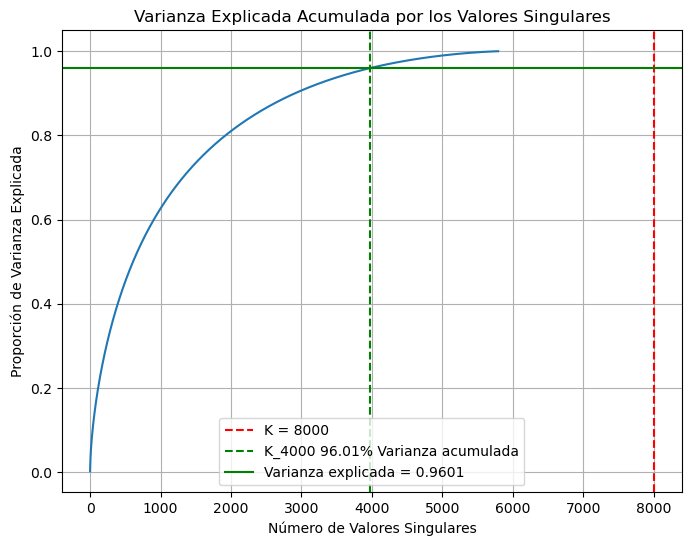

In [117]:
# Visualizar la varianza explicada acumulada
varianza_explicada_acumuladaTsvd = np.cumsum(svd.explained_variance_ratio_)
K_9601 = np.where(varianza_explicada_acumuladaTsvd >= 0.9601)[0][0]


plt.figure(figsize=(8, 6))
plt.plot(varianza_explicada_acumuladaTsvd)
plt.axvline(x=K, color='r', linestyle='--', label=f'K = {K}')
plt.axvline(x=K_9601, color='g', linestyle='--', label="K_4000 96.01% Varianza acumulada")
plt.axhline(y=0.9601, color='g', linestyle='-', label='Varianza explicada = 0.9601')

plt.title('Varianza Explicada Acumulada por los Valores Singulares')
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Proporción de Varianza Explicada')
plt.grid(True)
plt.legend() 
plt.show()

In [139]:
### K=4000
svd = TruncatedSVD(n_components=K)

# Ajustar y transformar las imágenes aplanadas
X_svd = svd.fit_transform(tfidf_matrix)
varianza_explicadaTsvd = np.sum(svd.explained_variance_ratio_)
print(f"Proporción de la varianza explicada por los primeros {K} valores singulares: {varianza_explicadaTsvd:.4f}")

Proporción de la varianza explicada por los primeros 8000 valores singulares: 1.0000


#### Estandarización de Variables

In [77]:
from sklearn.preprocessing import MaxAbsScaler
# MaxAbsScaler recommended for td-idf 
scaler = MaxAbsScaler()  # Scales each feature by its max absolute value
tfidf_matrix_scaled = scaler.fit_transform(X_svd)

#### Se define una función para crear un gridsearch

In [135]:
# Version 0

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from xgboost import XGBClassifier
import os

def create_search_grid() -> HalvingGridSearchCV:
    """
    Crea un objeto tipo HalvingGridSearchCV con los parámetros a evaluar.
    El pipeline contiene los siguientes pasos:
        - representation.
        - scaler.
        - classifier.
    Para el paso de representation se evalua TfidfVectorizer, y se evaluan por lo menos dos
    hiperparámetros de los mismos.
    Se  utiliza la métrica f1_macro para evaluar el desempeño de los modelos 

    Returns:
        (HalvingGridSearchCV) Objeto con el espacio de búsqueda definido.

    Examples:
    >>> search = create_search_grid()
    >>> print(search)
    HalvingGridSearchCV() # Dentro de los paréntesis se mostrarán los parámetros 
    definidos.
    """

    pipeline = Pipeline([
        ('representation', TfidfVectorizer()),
        ('scaler', MaxAbsScaler()),  # Scaling step added
        ('classifier', XGBClassifier(eval_metric='mlogloss')) 
    ])

    # Definimos el espacio de búsqueda para cada paso del pipeline
    param_grid = {
        'representation__max_df': [0.8, 1.0],
        'representation__min_df': [1, 5],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7]
    }

    # Realizamos la búsqueda de hiperparámetros
    search = HalvingGridSearchCV(
        pipeline,
        param_grid,
        cv=2,
        scoring='f1_macro',
        n_jobs=os.cpu_count(),
        min_resources="exhaust",
        factor=4
    )

    return search
    
   
    ## FIN DE IMPLEMENTACIÓN (NO MODIFICAR DESPUÉS ESTA LÍNEA)

search = create_search_grid()
print(search)

HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('representation',
                                               TfidfVectorizer()),
                                              ('scaler', MaxAbsScaler()),
                                              ('classifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             

In [129]:
# Function to determine optimal number of components for 95% variance
def find_optimal_svd_components(X_tfidf, threshold=0.95):
    svd = TruncatedSVD(n_components=min(8000, X_tfidf.shape[1]))  # Cap max components at 8000
    svd.fit(X_tfidf)

    explained_variance = np.cumsum(svd.explained_variance_ratio_)
    optimal_components = np.argmax(explained_variance >= threshold) + 1  # Find first component meeting threshold
    
    print(f"Optimal SVD components for {threshold*100:.1f}% variance: {optimal_components}")
    return optimal_components

In [130]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_clean)

optimal_svd_components = find_optimal_svd_components(X_train_tfidf)

Optimal SVD components for 95.0% variance: 3746


In [132]:
# Version 1 NO FUNCIONA!!!
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from xgboost import XGBClassifier
import os

def create_search_grid() -> HalvingGridSearchCV:
    """
    Crea un objeto tipo HalvingGridSearchCV con los parámetros a evaluar.
    El pipeline contiene los siguientes pasos:
        - representation.
        - scaler.
        - classifier.
    Para el paso de representation se evalua TfidfVectorizer, y se evaluan por lo menos dos
    hiperparámetros de los mismos.
    Se  utiliza la métrica f1_macro para evaluar el desempeño de los modelos 

    Returns:
        (HalvingGridSearchCV) Objeto con el espacio de búsqueda definido.

    Examples:
    >>> search = create_search_grid()
    >>> print(search)
    HalvingGridSearchCV() # Dentro de los paréntesis se mostrarán los parámetros 
    definidos.
    """

    pipeline = Pipeline([
        ('representation', TfidfVectorizer()),
        ('svd', TruncatedSVD(n_components=optimal_svd_components)), 
        ('scaler', MaxAbsScaler()),
        ('classifier', XGBClassifier(eval_metric='mlogloss'))
    ])

    # Define parameter grid
    param_grid = [
    {
        'representation__max_df': [0.8, 1.0],
        'representation__min_df': [1, 5],
        'svd__n_components': [optimal_svd_components - 50, optimal_svd_components, optimal_svd_components + 50],
        'classifier': [XGBClassifier(objective='multi:softmax', num_class=len(set(y_train)), eval_metric='mlogloss')],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.3]
    },
    {
        'representation__max_df': [0.8, 1.0],
        'representation__min_df': [1, 5],
        'svd__n_components': [optimal_svd_components - 50, optimal_svd_components, optimal_svd_components + 50],
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.01, 0.1, 1.0, 10.0]
    },
    {
        'representation__max_df': [0.8, 1.0],
        'representation__min_df': [1, 5],
        'svd__n_components': [optimal_svd_components - 50, optimal_svd_components, optimal_svd_components + 50],
        'classifier': [LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', solver='saga')],
        'classifier__C': [0.1, 1, 10]
    }
    ]
    
    from sklearn.model_selection import StratifiedKFold

    search = HalvingGridSearchCV(
        pipeline,
        param_grid,
        cv=StratifiedKFold(n_splits=5),
        scoring='f1_macro',
        n_jobs=os.cpu_count(),
        min_resources="exhaust",
        factor=4
    )

    return search

In [136]:
search = create_search_grid()
print(search)

HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('representation',
                                               TfidfVectorizer()),
                                              ('scaler', MaxAbsScaler()),
                                              ('classifier',
                                               XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             

In [137]:
search.fit(X_train_clean, y_train_encoded)

print("Puntaje del mejor modelo en validación cruzada: {:.2f}".format(search.best_score_))
print("Parámetros del mejor modelo:\n{}\n".format(search.best_params_))

Puntaje del mejor modelo en validación cruzada: 0.78
Parámetros del mejor modelo:
{'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'representation__max_df': 1.0, 'representation__min_df': 1}



In [138]:
df_results = pd.DataFrame(search.cv_results_)
df_results = df_results.sort_values(by='rank_test_score')
df_results.head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,param_representation__max_df,param_representation__min_df,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
45,2,5792,28.335235,0.038224,0.281953,0.008899,7,100,1.0,1,"{'classifier__max_depth': 7, 'classifier__n_es...",0.773493,0.782727,0.778110,0.004617,1,1.0,1.0,1.0,0.0
47,2,5792,38.004042,0.198804,0.345920,0.014433,7,200,1.0,1,"{'classifier__max_depth': 7, 'classifier__n_es...",0.771849,0.784299,0.778074,0.006225,2,1.0,1.0,1.0,0.0
46,2,5792,37.928797,0.051687,0.351998,0.006716,7,200,0.8,1,"{'classifier__max_depth': 7, 'classifier__n_es...",0.771849,0.784299,0.778074,0.006225,2,1.0,1.0,1.0,0.0
37,1,1448,6.935962,0.059698,0.074689,0.001977,7,200,0.8,1,"{'classifier__max_depth': 7, 'classifier__n_es...",0.653660,0.702285,0.677973,0.024313,4,1.0,1.0,1.0,0.0
38,1,1448,6.801820,0.090441,0.088784,0.001031,7,200,1.0,1,"{'classifier__max_depth': 7, 'classifier__n_es...",0.653660,0.702285,0.677973,0.024313,4,1.0,1.0,1.0,0.0
36,1,1448,4.688649,0.080020,0.062944,0.016591,7,100,1.0,1,"{'classifier__max_depth': 7, 'classifier__n_es...",0.651413,0.704420,0.677916,0.026504,6,1.0,1.0,1.0,0.0
44,1,1448,3.538143,0.096831,0.034854,0.000270,5,100,0.8,1,"{'classifier__max_depth': 5, 'classifier__n_es...",0.660847,0.693325,0.677086,0.016239,7,1.0,1.0,1.0,0.0
43,1,1448,4.235382,0.157260,0.055371,0.002616,5,100,1.0,1,"{'classifier__max_depth': 5, 'classifier__n_es...",0.660847,0.693325,0.677086,0.016239,7,1.0,1.0,1.0,0.0
40,1,1448,6.554990,0.035702,0.077053,0.000060,5,200,0.8,1,"{'classifier__max_depth': 5, 'classifier__n_es...",0.661159,0.690737,0.675948,0.014789,9,1.0,1.0,1.0,0.0
39,1,1448,6.438332,0.161191,0.067547,0.004494,5,200,1.0,1,"{'classifier__max_depth': 5, 'classifier__n_es...",0.661159,0.690737,0.675948,0.014789,9,1.0,1.0,1.0,0.0


#### Procedimiento y Análsis:

XXXX